# Grafici Trasmittanza Spettrofotometro


In [1]:
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd
import numpy as np
from Functions_Tries.transmittance import Transmittance
from Functions_Tries.Spectrofotometer_Thickness import iterazione
from pathlib import Path

plt.style.use("seaborn-v0_8-darkgrid")

# Il codice seguente serve al fit dello spessore dagli spettri ottenuti dallo spettrofotometro

- Usiamo la libreria ```matplotlib.pyplot``` per graficare gli spettri
- Usiamo la libreria ```numpy``` per avere la matematica corretta e dei contenitori efficenti.
- Usiamo la libreria ```scipy.interpolate``` per avere le curve di Bezier per interpolare i dati ottenuti dal Johnson
- Usiamo la libreria ```pandas``` per leggere i file che contengono gli spettri e per l'output
- Stefano ha scritto il modulo ```Function_Tries.transmittance``` per avere le funzioni su cui fare il fit e per fare il primo test di fattibilità sui fit
- Stefano e Francesco hanno scritto il modulo ```Function_Tries.Spectrofotometer_Thickness``` per fare i fit e automatizzare tutti i processi
- Usiamo il modulo ```pathlib``` per gestire i Path dei vari file in maniera automatizzata

## TODO

- [ ] Rendere un filo più veloce spettrofotometro

In [2]:
# Imposto la precisione per l'output dei numeri
np.set_printoptions(precision=2)

# Path entro cui fare le ricerche
dir = Path("./data/")

# Nome colonne for pretty printing
colonne = ["NomeFile", "ValoreFit", "ErrFit", "χ_2_Rid", "GdL"]

# Liste vuote, servono per salvare i vari dati del fit
data_Beer_Lambert = dict(
    NomeFile = [],
    ValoreFit = [],
    ErrFit = [],
    χ_2_Rid = [],
    GdL = []
)

data_Transmittance_approx = dict(
    NomeFile = [],
    ValoreFit = [],
    ErrFit = [],
    χ_2_Rid = [],
    GdL = []
)

data_Transmittance_approx_n_free = dict(
    NomeFile = [],
    ValoreFit = [],
    ErrFit = [],
    n_obt = [],
    err_n = [],
    χ_2_Rid = [],
    GdL = []
)


data_Transmittance_exact = dict(
    NomeFile = [],
    ValoreFit = [],
    ErrFit = [],
    χ_2_Rid = [],
    GdL = []
)

data_Transmittance_exact_n_free = dict(
    NomeFile = [],
    ValoreFit = [],
    ErrFit = [],
    n_obt = [],
    err_n = [],
    χ_2_Rid = [],
    GdL = []
)



In [3]:
# leggo dati del johnny
john = pd.read_csv("./data/book_data/Johnson.csv")
n_spl_john = CubicSpline(john["wl"], john["n"])
k_spl_john = CubicSpline(john["wl"], john["k"])

 # Inizializziamo la classe che contiene le transmittance per i successivi fit
Trans = Transmittance(
    n=n_spl_john,
    k=k_spl_john,
    n_0=1.0,
    n_1=1.51,
)

In [4]:
# Finalmente lanciamo la cazzo di funzione
iterazione(
    dir,
    data_Beer_Lambert,
    Trans.beer_lambert,
    graph_title="Fit Beer Lambert",
    p0=60e-9,
    graph_dir="./images/beer_lambert/",
    opt_bound = (0, 1e-6)
)


/home/pilo/lab_mat/Functions_Tries/Spectrofotometer_Thickness.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


In [5]:
iterazione(
    dir,
    data_Transmittance_approx,
    Trans.transmittance_approx,
    graph_title="Fit Transmitance",
    p0=60e-9,
    graph_dir="./images/transmittance_approx/",
    opt_bound=(0, 1e-6),
)

In [7]:
iterazione(
    dir,
    data_Transmittance_approx_n_free,
    Trans.transmittance_approx_n_free,
    graph_title="Fit Transmittance, $n_1$ free",
    p0=(1.52, 60e-9),
    graph_dir="./images/transmittance_approx_n_free/",
    opt_bound = ([1, 0], [2, 1e-6])
)


In [8]:

iterazione(
    dir,
    data_Transmittance_exact,
    Trans.transmittance_exact,
    graph_title="Fit Transmitance",
    p0=60e-9,
    graph_dir="./images/transmittance_exact/",
    opt_bound = (0, 1e-6)
)


In [10]:

iterazione(
    dir,
    data_Transmittance_exact_n_free,
    Trans.transmittance_exact_n_free,
    graph_title="Fit Transmittance, $n_1$ free",
    p0=(1.52, 60e-9),
    graph_dir="./images/transmittance_exact_n_free/",
    opt_bound = ([1, 0], [2, 1e-6])
)

In [ ]:

# SALVATAGGIO DATI BEER LAMBERT SU FILE
res_df_beer_lambert = pd.DataFrame(data_Beer_Lambert)
res_df_beer_lambert.to_csv(
    "Risultati_Beer_Lambert_spettrofotometro.csv", index=False
)
res_df_beer_lambert = pd.DataFrame(data_Transmittance_approx)
res_df_beer_lambert.to_csv(
    "Risultati_Transmittance_approx_spettrofotometro.csv", index=False
)
res_df_beer_lambert = pd.DataFrame(data_Transmittance_approx_n_free)
res_df_beer_lambert.to_csv(
    "Risultati_Transmittance_approx_n_free_spettrofotometro.csv", index=False
)
res_df_beer_lambert = pd.DataFrame(data_Transmittance_exact)
res_df_beer_lambert.to_csv(
    "Risultati_Transmittance_exact_spettrofotometro.csv", index=False
)
res_df_beer_lambert = pd.DataFrame(data_Transmittance_exact_n_free)
res_df_beer_lambert.to_csv(
    "Risultati_Transmittance_exact_n_free_spettrofotometro.csv", index=False
)

# Immagini dello spettrofotometro, 26 Maggio

In [ ]:
dfs = []

for file in Path("data/26-05_spettrofotometro/ELAB/").iterdir():
    if file.match("Oro*"):
        dfs.append([pd.read_csv(file), file])

In [ ]:
dfs

[[            lambda  transmittance  polished  trasm_error
  0     9.000000e-07         0.7580  0.268157     0.004243
  1     8.995000e-07         0.7512 -1.843888     0.004243
  2     8.990000e-07         0.6165 -2.087001     0.004243
  3     8.985000e-07         0.6457  0.277816     0.004243
  4     8.980000e-07         0.6642  0.152053     0.004243
  ...            ...            ...       ...          ...
  1096  3.520000e-07         0.9742  0.833148     0.004243
  1097  3.515000e-07         0.9709  0.827918     0.004243
  1098  3.510000e-07         0.9770  0.823777     0.004243
  1099  3.505000e-07         0.9722  0.834148     0.004243
  1100  3.500000e-07         0.9814  0.848228     0.004243
  
  [1101 rows x 4 columns],
  PosixPath('data/26-05_spettrofotometro/ELAB/Oro7_Aria_1.csv')],
 [            lambda  transmittance  polished  trasm_error
  0     9.000000e-07         0.2537  0.089751     0.004243
  1     8.995000e-07         0.2603 -0.638930     0.004243
  2     8.990000e-0

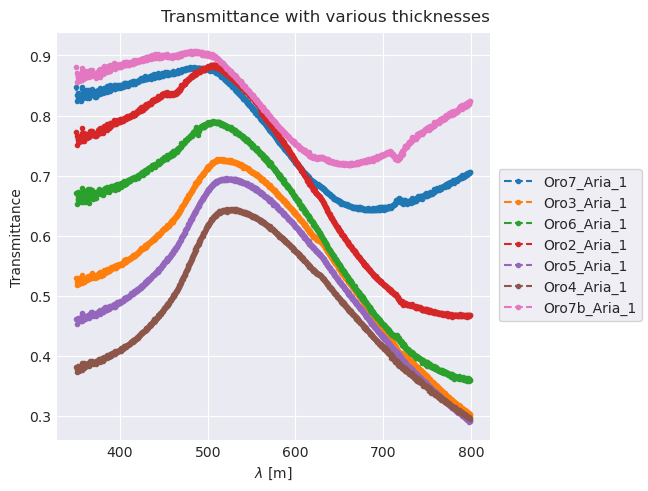

In [ ]:
fig, ax = plt.subplots(layout="constrained")
for df in dfs:
    name = df[1].stem
    data = df[0]
    data = data[data["lambda"]<800e-9]
    ax.plot( data["lambda"]*1e9, data["polished"],".--", label=str(name))

ax.set_xlabel("$\\lambda$ [m]")
ax.set_ylabel("Transmittance")
fig.suptitle("Transmittance with various thicknesses")
fig.legend(loc="outside right", frameon=True)


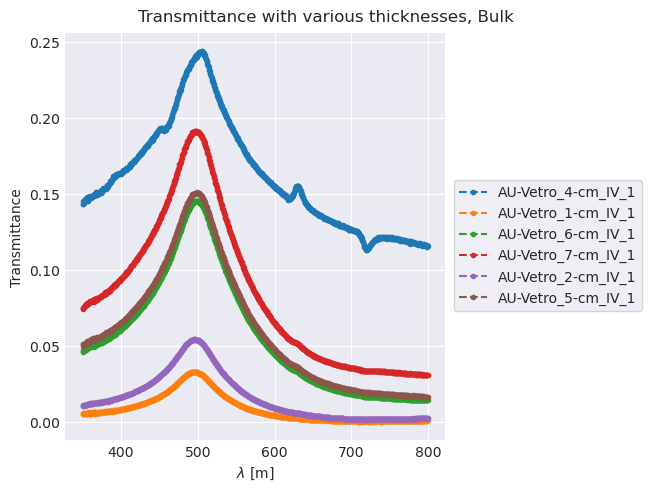

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

plt.style.use("seaborn-v0_8-darkgrid")

bulk = []

for file in Path("data/12-05_spettrofotometro/ELAB/").iterdir():
    if file.match("AU*"):
        bulk.append([pd.read_csv(file), file])

fig, ax = plt.subplots(layout="constrained")

for df in bulk:
    name = df[1].stem
    data = df[0]
    data = data[data["lambda"]<800e-9]
    ax.plot( data["lambda"]*1e9, data["polished"],".--", label=str(name))

ax.set_xlabel("$\\lambda$ [m]")
ax.set_ylabel("Transmittance")
fig.suptitle("Transmittance with various thicknesses, Bulk")
fig.legend(loc="outside right", frameon=True)